In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import STOPWORDS, WordCloud
%matplotlib inline

### Read Data
In this dataset, we mainly use columns **essay** and **domain1_score** when building our automatic essay grading tasks. The **essay** column contain the text of essays, each essay will be graded by two graders, the scores are displayed in column rater1_domain1, rater2_domain1. The **domain1_scoer** represents the final score of the essay, which is the summation of both graders' scores. Only when there is huge discrepancy between both socres will a third grader is used to generate rater3_domain1 score. This case happens rarely and only in prompt 8 so it is safe to ignore this small edge case.

In [3]:
train_data=pd.read_excel("training_set_rel3.xls")
val_data=pd.read_excel("valid_set.xls")

In [4]:
train_data.head()

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,...,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
0,1,1,"Dear local newspaper, I think effects computer...",4.0,4.0,NaN,8.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5.0,4.0,NaN,9.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4.0,3.0,NaN,7.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5.0,5.0,NaN,10.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,"Dear @LOCATION1, I know having computers has a...",4.0,4.0,NaN,8.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Missing Values

We then check the percentage of missing values in columns that are most revelant to our task. There is no missing value in **essay** column, our groundtruth column **domain1_score** contains almost no missing values(0.007% missingness).

In [6]:
# Train: Percentage of Missing Values
cols = ['essay_id', 'essay_set', 'essay', 'rater1_domain1', 'rater2_domain1',
       'rater3_domain1', 'domain1_score']
train_data[cols].isnull().sum()/train_data.shape[0]

essay_id          0.000000
essay_set         0.000000
essay             0.000000
rater1_domain1    0.000077
rater2_domain1    0.000077
rater3_domain1    0.990137
domain1_score     0.000077
dtype: float64

In [7]:
# Test: Percentage of Missing Values
val_data.isnull().sum()/val_data.shape[0]

essay_id                0.000000
essay_set               0.000000
essay                   0.000000
domain1_predictionid    0.000000
domain2_predictionid    0.857752
dtype: float64

## Exploratory Data Analysis

In [8]:
#drop NA
train_data=train_data[~train_data.domain1_score.isnull()]

In [9]:
#utils function to check essay word count
def len_essay(essay):
    return len(essay.split())

train_data['essay_len']=train_data.essay.apply(len_essay)
val_data['essay_len']=val_data.essay.apply(len_essay)

### Essay Count by Essay Set
There are arouund 1500 essays for each prompt except for essays from set 8. It informs us that training an LSTM network may result in less optimal model performance since we do not have sufficiently large datasets for the model to understand what constitutes high/low score essays. A pre-trained model like BERT could be a good choice if we want to boost the model performance.

In [10]:
for i in range(1,9):
    print(f'number of essays from set {i} in train data is : {train_data[train_data.essay_set==i].shape[0]}')

number of essays from set 1 in train data is : 1783
number of essays from set 2 in train data is : 1800
number of essays from set 3 in train data is : 1726
number of essays from set 4 in train data is : 1771
number of essays from set 5 in train data is : 1805
number of essays from set 6 in train data is : 1800
number of essays from set 7 in train data is : 1569
number of essays from set 8 in train data is : 723


In [21]:
for i in range(1,9):
    print(f'number of essays from set {i} in validation data is : {val_data[val_data.essay_set==i].shape[0]}')

number of essays from set 1 in validation data is : 589
number of essays from set 2 in validation data is : 600
number of essays from set 3 in validation data is : 568
number of essays from set 4 in validation data is : 586
number of essays from set 5 in validation data is : 601
number of essays from set 6 in validation data is : 600
number of essays from set 7 in validation data is : 441
number of essays from set 8 in validation data is : 233


### Score Distribution By Essay Set

One observation after examining the plots below is that the essays coming from different sets are evaluated on different scales. For instance, the third essay set is on the scale of 0-3, while the set 7 is on the scale of 0-25. It raises the question that whether we align the scales of essay scores for all the prompts to generate a single model, or train models separately for essay prompt. It requires us to look the similarity of text for each essay prompt to decide on this issue, word clouds for each set are included at the end of our anlaysis.

Another observation is that, despite difference in scale, the distribution of essay scores are not quite similar among eight essay sets. Even though they are all somewhat left skewed but it's to different extent.

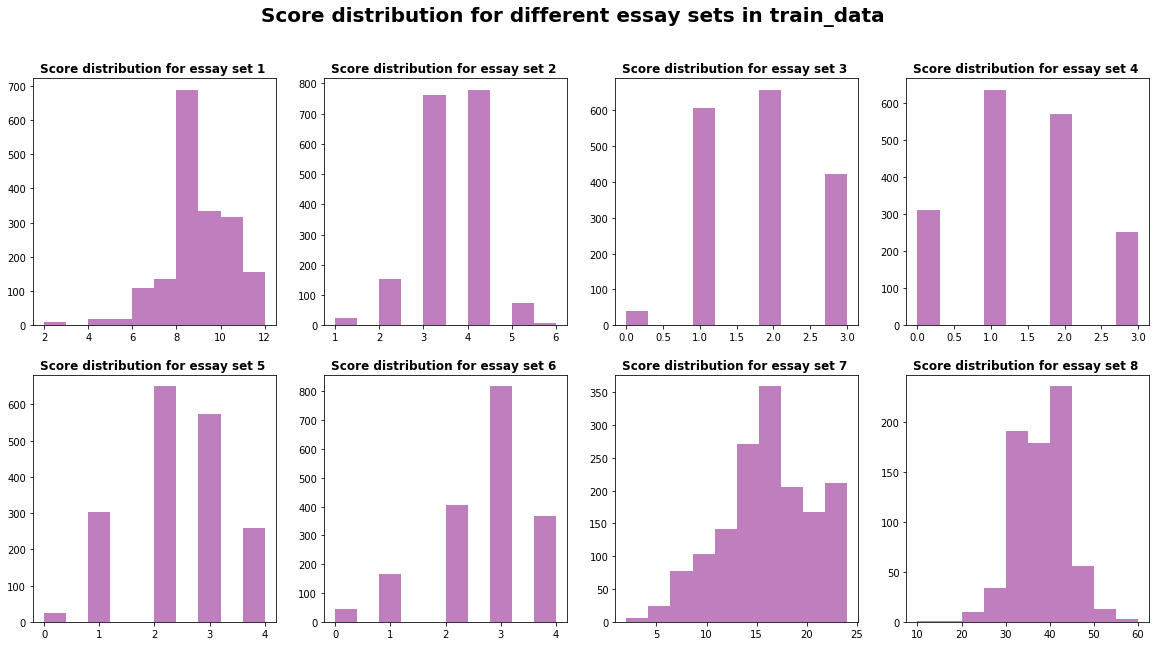

In [11]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
for i, ax in enumerate(axes.flat):
    ax.hist(train_data[train_data.essay_set==(i+1)].domain1_score,color='purple',alpha=0.5)
    ax.set_title(f'Score distribution for essay set {i+1} ',fontsize=12,fontweight='bold')
    #ax.set_xlim(0,60)
fig.suptitle('Score distribution for different essay sets in train_data',fontweight='bold',fontsize=20)
#plt.tight_layout()
plt.show()

### Word Count by Essay Set

By looking at the word count distribution of both train and vaidation data, it shows two things. First, the word coutn distribution tend to be right skewed, except for essay set 8 where the peak occurs at the maximum. The second observation is that for both train and validation data of the same essay set share the same word count distribution, which is good when evaluating model prediction.

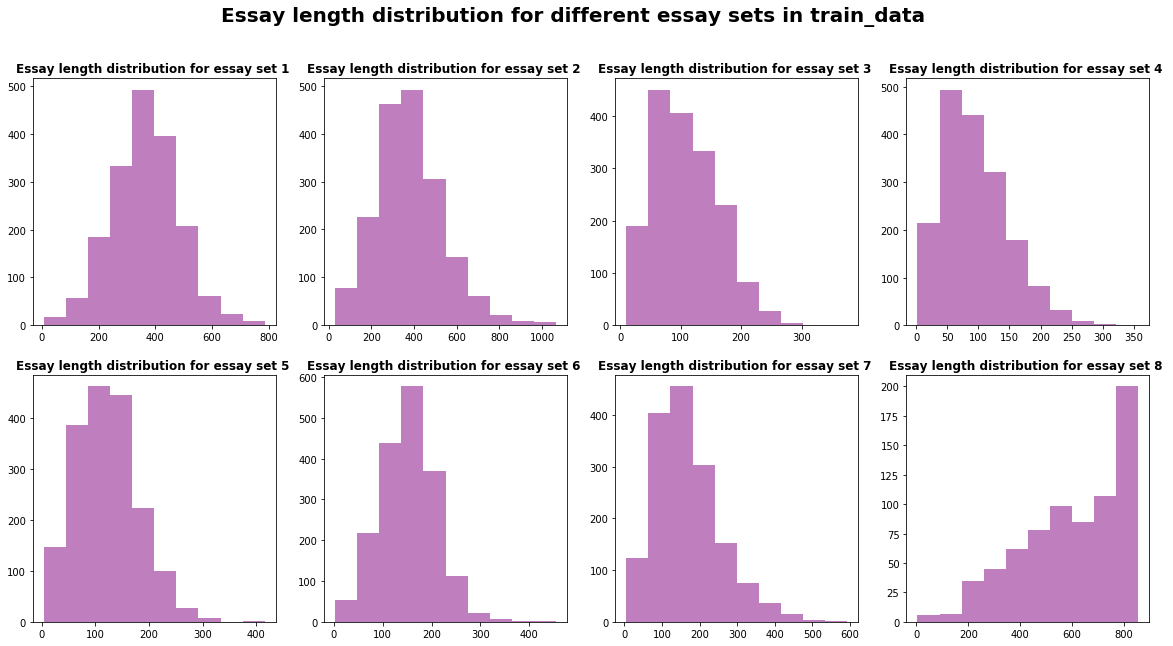

In [12]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
for i, ax in enumerate(axes.flat):
    ax.hist(train_data[train_data.essay_set==(i+1)].essay_len,color='purple',alpha=0.5)
    ax.set_title(f'Essay length distribution for essay set {i+1} ',fontsize=12,fontweight='bold')
fig.suptitle('Essay length distribution for different essay sets in train_data',fontweight='bold',fontsize=20)
#plt.tight_layout()
plt.show()

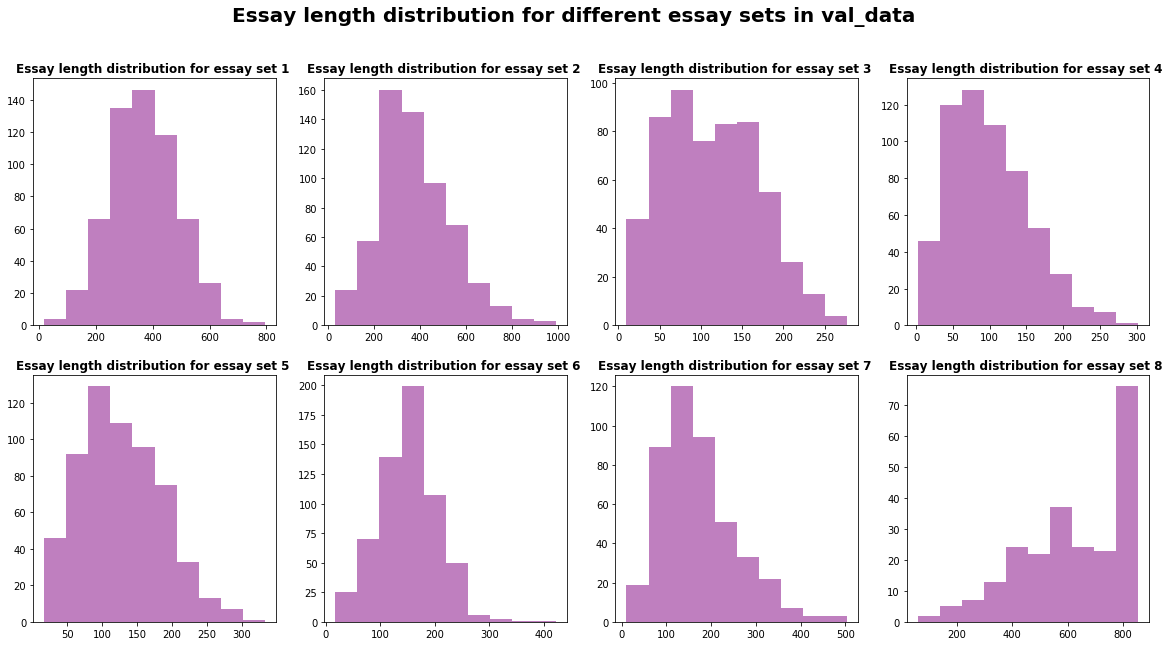

In [13]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
for i, ax in enumerate(axes.flat):
    ax.hist(val_data[val_data.essay_set==(i+1)].essay_len,color='purple',alpha=0.5)
    ax.set_title(f'Essay length distribution for essay set {i+1} ',fontsize=12,fontweight='bold')
fig.suptitle('Essay length distribution for different essay sets in val_data',fontweight='bold',fontsize=20)
#plt.tight_layout()
plt.show()

### Length vs. Essay Score

We also take a look at the relationship between essay length(word count) and essay score by essay set. The trend is shared for all the essay sets despite they are of different scales. It is observed that the longer essay is associated with higher scores by looking at the median of each boxplots. Word count can be a useful indicator in our automatic essay grading system.

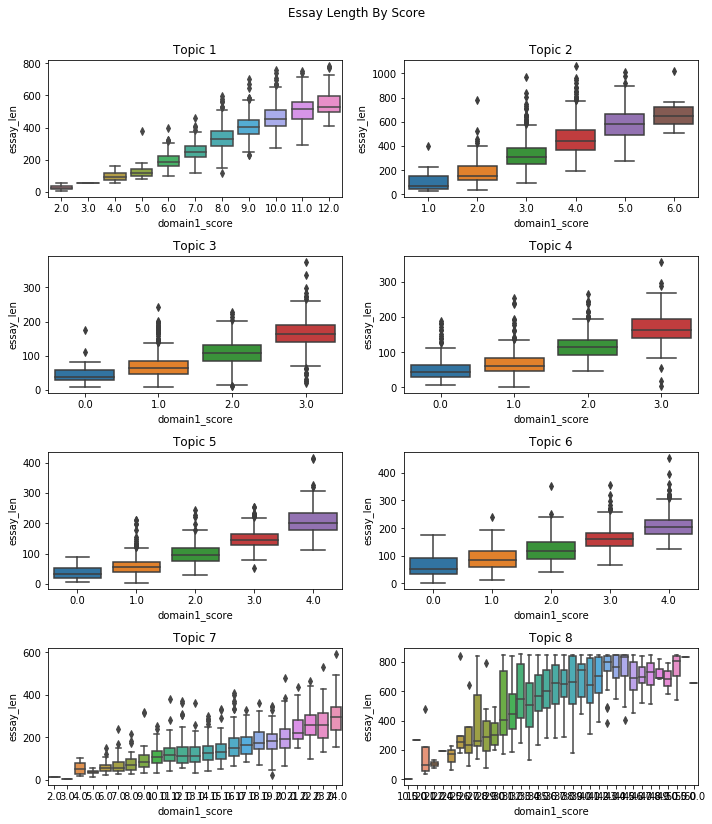

In [15]:
topic_number = 0
fig, ax = plt.subplots(4,2, figsize=(10,12))
for i in range(4):
    for j in range(2):
        topic_number += 1
        sns.boxplot(x='domain1_score', y='essay_len', data=train_data[train_data['essay_set'] == topic_number], ax=ax[i,j])
        ax[i,j].set_title('Topic %i' % topic_number)
plt.suptitle('Essay Length By Score')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Word Cloud : High/Low Score Essay

Within each essay set, we create word cloud for essays that receive either high or low score. When examining within essay set, it seems like there is no clear difference in the top words generated from both high and low score essays. It makes sense to us since the word cloud is created based on word frequency, and the most frequent words tend to be topic words mentioned in the prompt. For instance, for essay set 1 that asks people to 'state your opinion on the effects computers have on people', words such as computer and people are highlighted in the word cloud. 

When examining essay similarity across essay set, we found that the since the essay sets ask about different topics in life, the top keywords for different essay sets are drastically different. Thus, we think it may not be a good idea to rescale the scores of all the essay sets and generate a single model for all the sets since the essays answering to different prompt could be inheritently incomparable. Also, practically speaking, a real-life essay scoriong system should not adopt a one-for-all evaluation criterion for essays that of different topics.

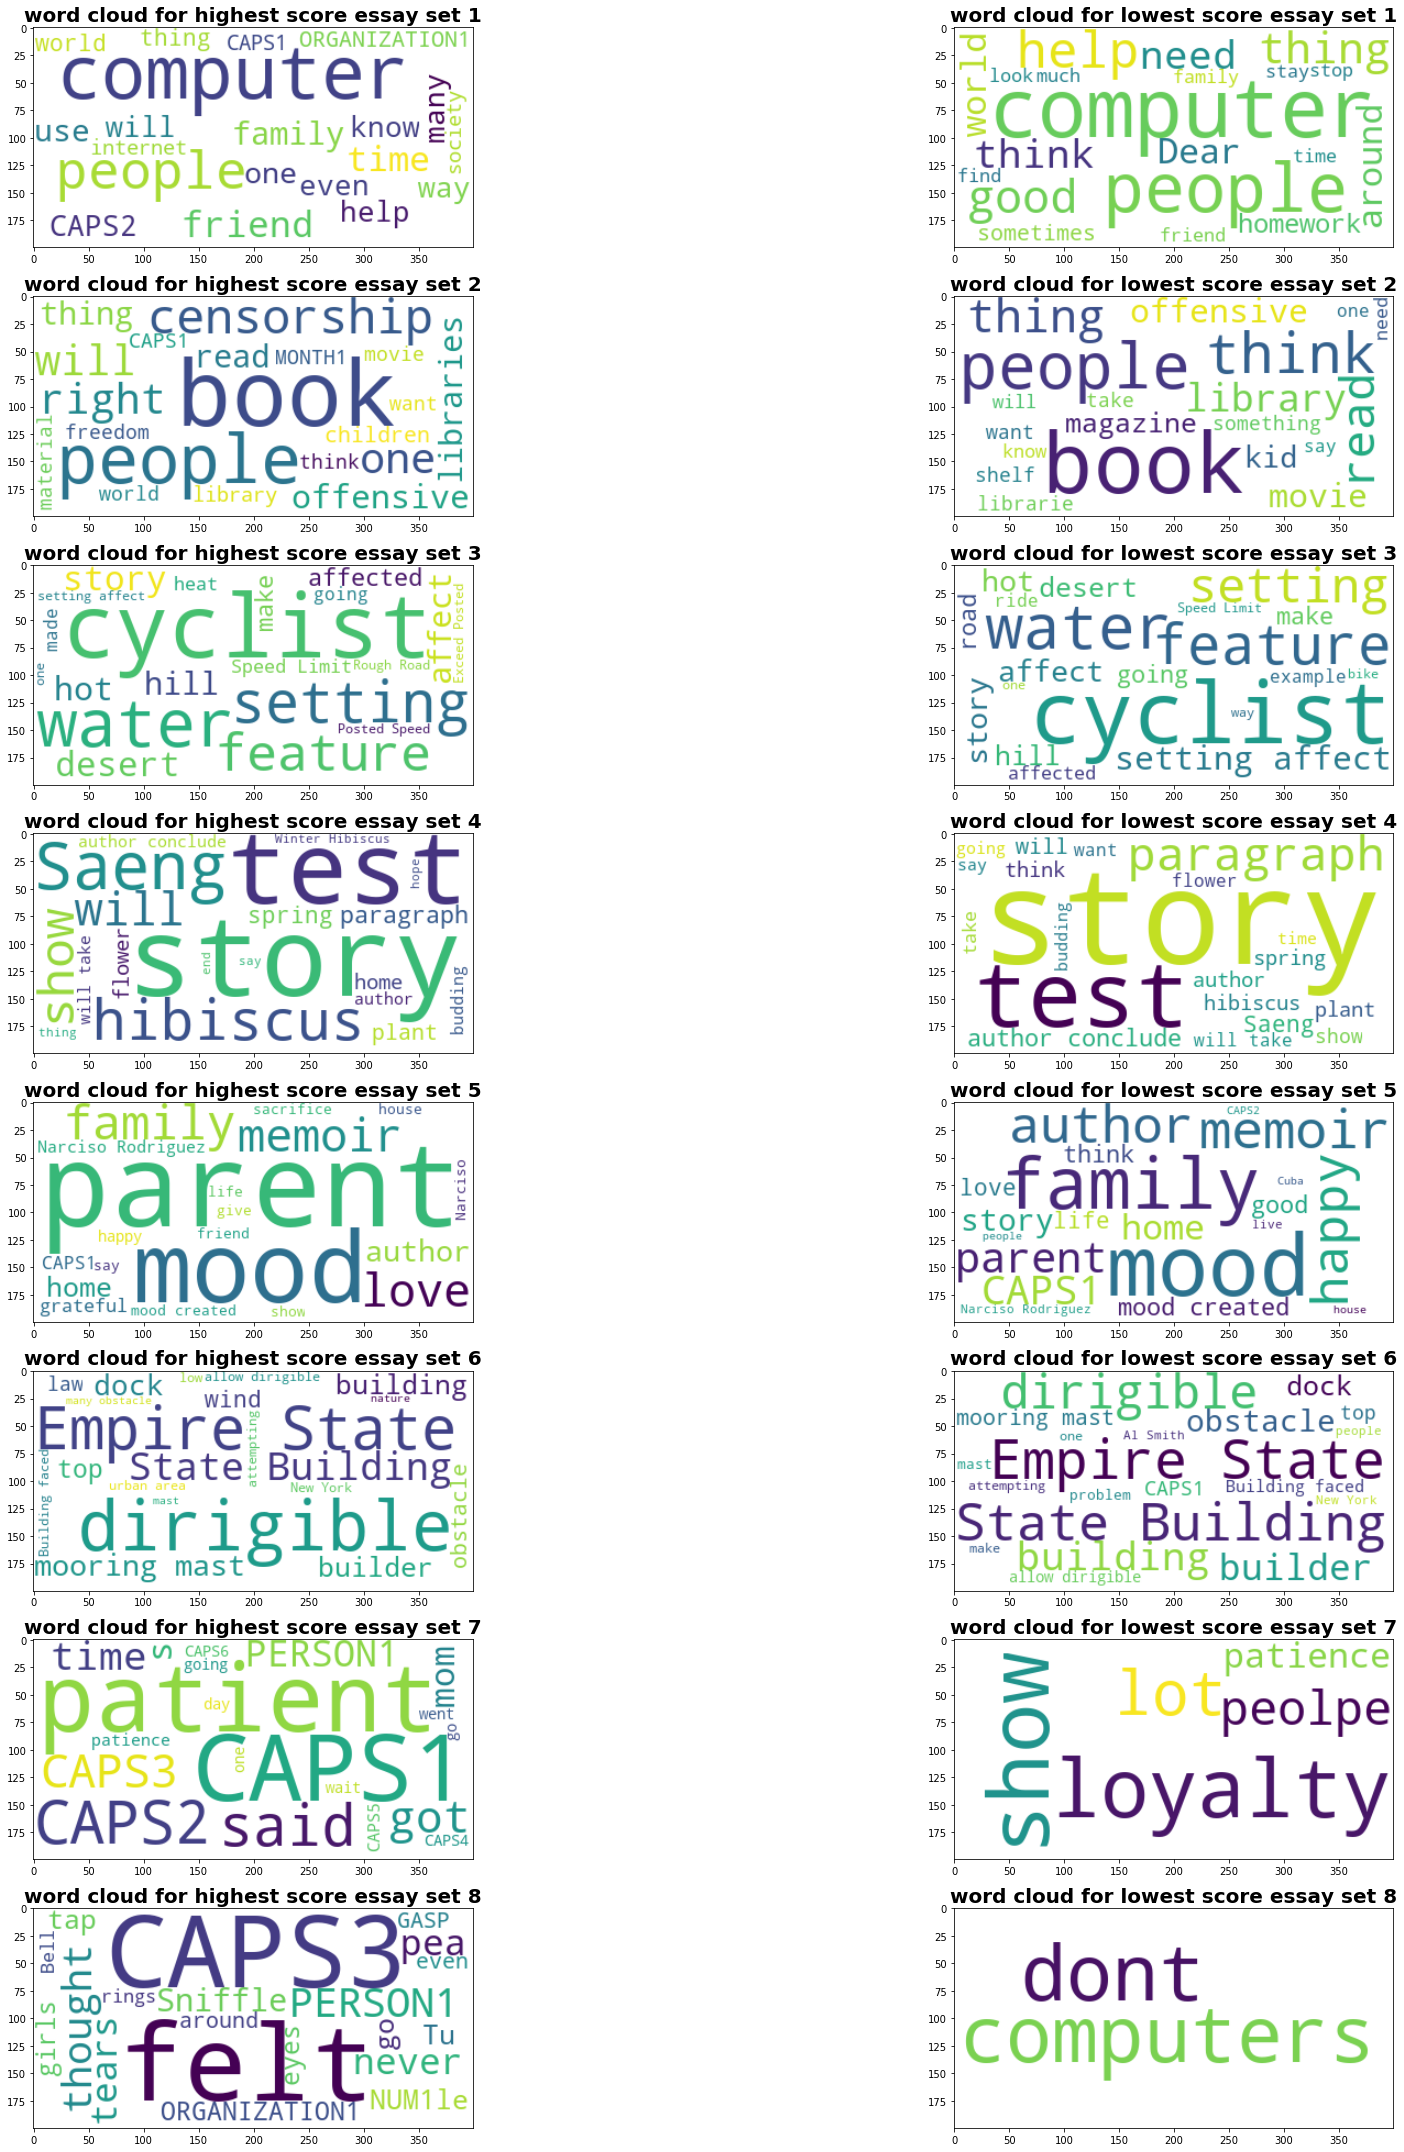

In [20]:
fig, axes = plt.subplots(8, 2, figsize=(30, 30))
for i in range(1,9):
    essay_set=train_data[train_data.essay_set==i]
    max_score=essay_set[essay_set.domain1_score>=essay_set.domain1_score.max()-1]
    min_score=essay_set[essay_set.domain1_score<=essay_set.domain1_score.min()+1]
    max_essay = " ".join(max_score['essay'].dropna())
    wc_max = WordCloud(stopwords=STOPWORDS, background_color="white", max_words=20)
    wc1 = wc_max.generate(max_essay)
    axes[i-1][0].imshow(wc1, interpolation="bilinear")
    axes[i-1][0].set_title(f'word cloud for highest score essay set {i}',fontsize=20,fontweight='bold')
    min_essay = " ".join(min_score['essay'].dropna())
    wc_min= WordCloud(stopwords=STOPWORDS, background_color="white", max_words=20)
    wc2 = wc_min.generate(min_essay)
    axes[i-1][1].imshow(wc2, interpolation="bilinear")
    axes[i-1][1].set_title(f'word cloud for lowest score essay set {i}',fontsize=20,fontweight='bold')
plt.tight_layout()
plt.show()